In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet as cc
import seaborn as sns
from copy import deepcopy
from toolz import partial, concat, keyfilter
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit, GridSearchCV, cross_val_score
from aging.behavior.modeling import JaxRegressor, multi_model_function, model_loss_l1
from aging.plotting import legend, format_plots, save_factory, figure, PlotConfig

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "beh-stabilization", tight_layout=False)

## Longtogeny

In [80]:
version = 7  # arhmm version
df = pd.read_parquet(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longtogeny_males_clean_pseudotime_v2.parquet"
)
df.set_index(['pseudo_age', 'pseudo_age_smooth'], inplace=True, append=True)
df = df[df.index.get_level_values('age') < 600]

In [81]:
coef_shapes = {
    "exponential_params": dict(a=(1, 1), b=(1, 1), c=(1, 1), offset=(1, 1)),
    "linear_params": dict(m=(1, 1), b=(1, 1)),
    "logistic_params": dict(m=(1, 1), b=(1, 1), offset=(1, 1), scale=(1, 1)),
    "quadratic_params": dict(a=(1, 1), b=(1, 1), c=(1, 1)),
    "submodel_weights": (4, 1),
}

In [82]:
mdl = JaxRegressor(
    jit=True,
    model=multi_model_function,
    loss_fun=model_loss_l1,
    n_iter=50,
    coef_shapes=coef_shapes,
    l1=1e-1,
    lr=1e-1,
)

In [83]:
params = dict(l1=np.logspace(-5, 0, 6))

In [84]:
age_scaler = StandardScaler()
x = age_scaler.fit_transform(df.index.get_level_values('pseudo_age').to_numpy()[:, None])
y = StandardScaler().fit_transform(df)
time = np.linspace(np.min(x), np.max(x), 300)[:, None]

In [85]:
# # cv = GridSearchCV(mdl, params, cv=ShuffleSplit(n_splits=3, test_size=0.4, random_state=0))
# best_mdls = {}
# grads = {}
# for syll in tqdm(range(50)):
#     # cv = cv.fit(x, y[:, syll])
#     # best_mdls[syll] = deepcopy(cv.best_estimator_)
#     # grads[syll] = cv.best_estimator_.gradient(time)
#     best_mdls[syll] = deepcopy(mdl.fit(x, y[:, syll]))
#     grads[syll] = mdl.gradient(time)

In [86]:
best_mdls = {}
grads = {}
scores = {}
for syll in tqdm(range(50)):
    scores[syll] = cross_val_score(
        mdl, x, y[:, syll], cv=ShuffleSplit(n_splits=4, test_size=0.35, random_state=0)
    )
    est = deepcopy(mdl).fit(x, y[:, syll])
    best_mdls[syll] = est
    grads[syll] = est.gradient(time)

  0%|          | 0/50 [00:00<?, ?it/s]

In [90]:
score_thresh = 0.15
keep_mdls = keyfilter(lambda k: scores[k].mean() > score_thresh, best_mdls)
keep_grads = keyfilter(lambda k: scores[k].mean() > score_thresh, grads)

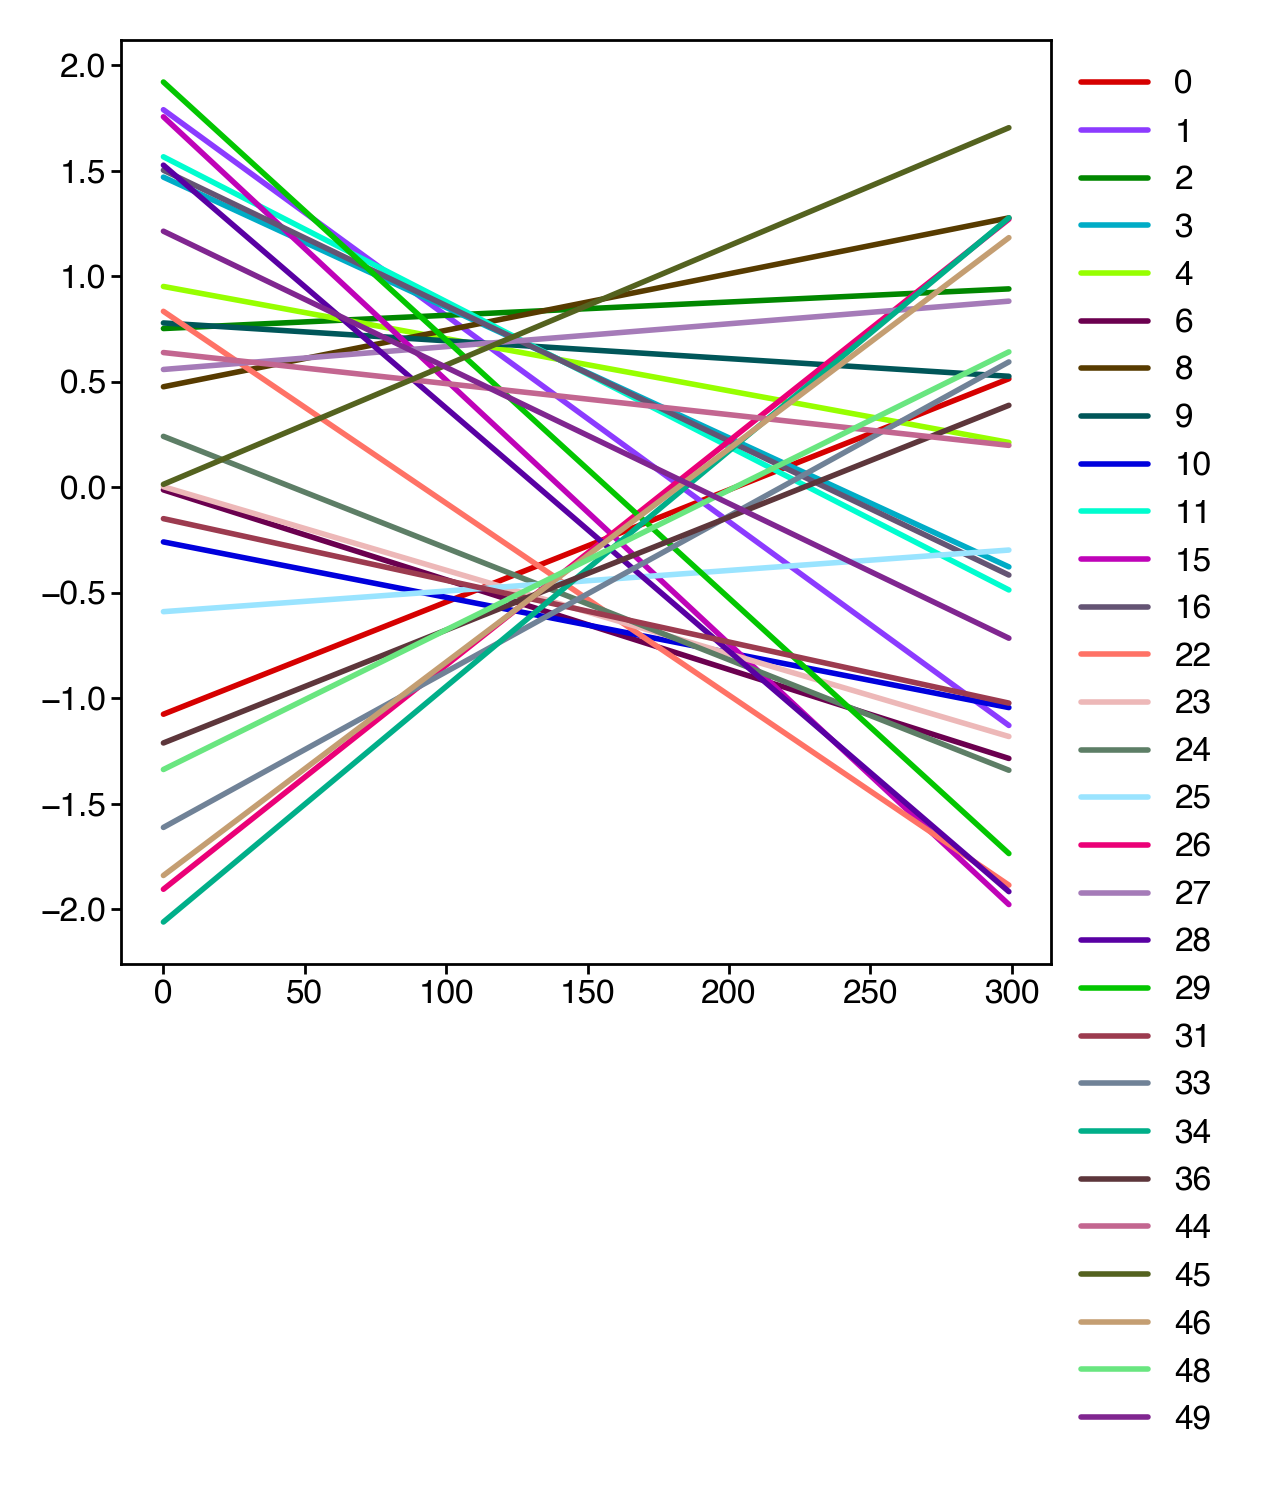

In [91]:
for k, v in keep_grads.items():
    plt.plot(v, label=k, c=cc.glasbey[k])
legend()

In [92]:
grad_array = np.array(list(keep_grads.values()))

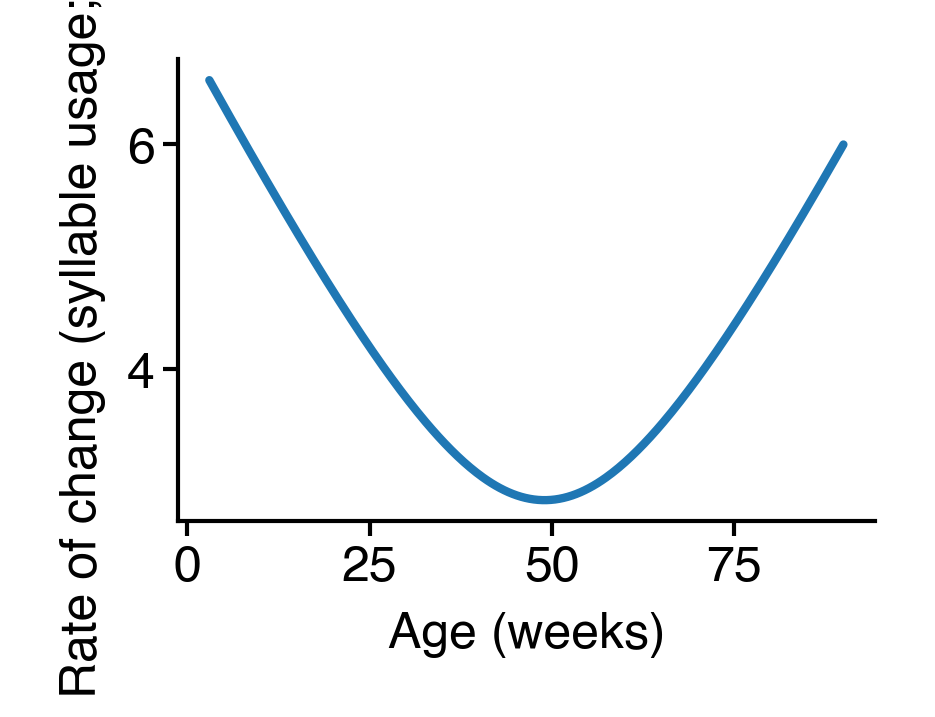

In [93]:
fig = figure(1.5, 1)
plt.plot(age_scaler.inverse_transform(time), np.linalg.norm(grad_array, axis=0))
plt.ylabel("Rate of change (syllable usage; a.u.)")
plt.xlabel('Age (weeks)')
sns.despine()
saver(fig, "longtogeny-v1-males-rate-of-change");

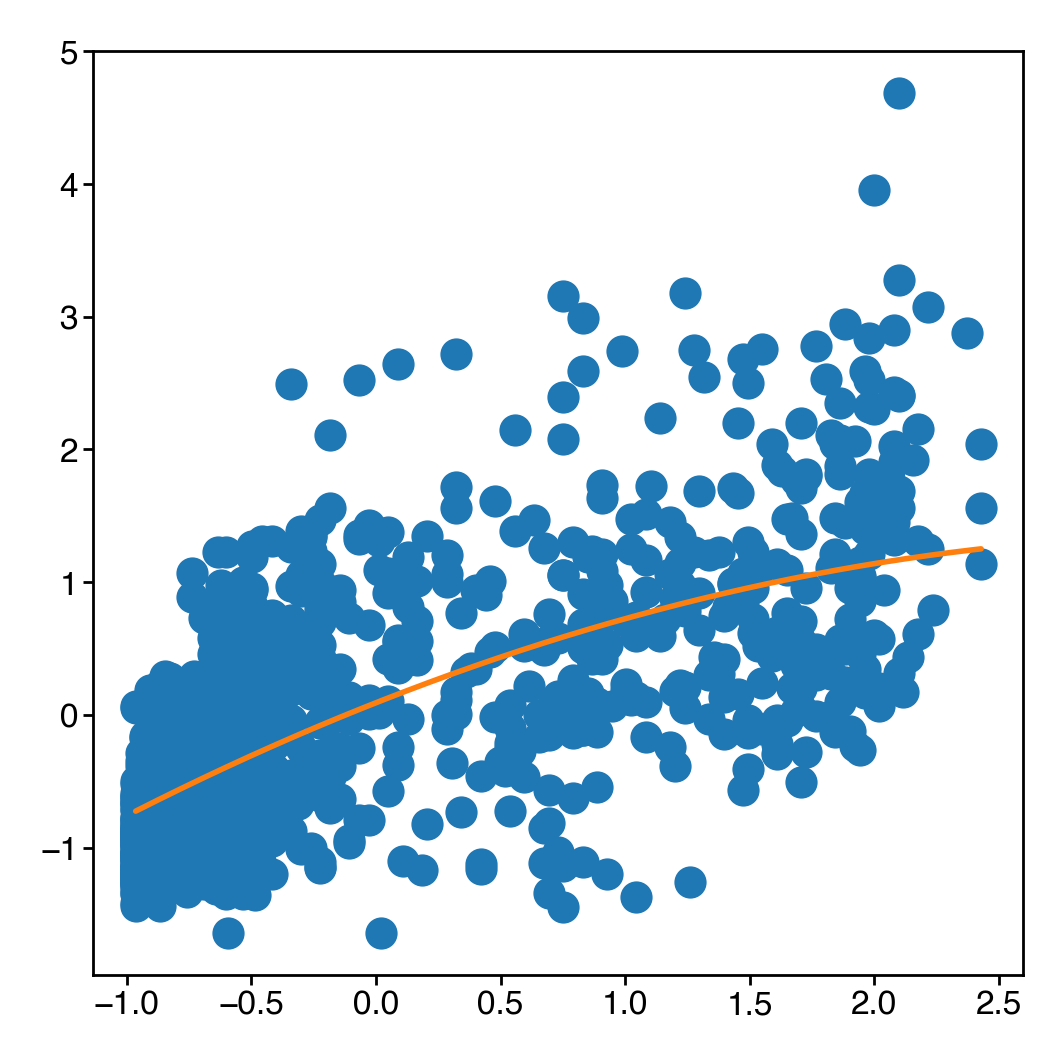

In [94]:
syll_ = 4
plt.plot(x, y[:, syll_], 'o')
plt.plot(time, keep_mdls[syll_].predict(time))

## Ontogeny

### Males

In [3]:
version = 7  # arhmm version
df = pd.read_parquet(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_clean_pseudotime_v02.parquet"
)

df.set_index(['pseudotime_rank', 'pseudotime_dist'], inplace=True, append=True)

In [4]:
df = df.sort_index(level='pseudotime_rank')

In [5]:
count_map = df.groupby('age')['0'].count()
count_map

age
3     16
5     16
7     16
9     16
12    16
16    16
20    16
24    16
28    16
32    16
36    16
52    16
56    16
72    16
78    16
80    15
84    16
90    16
Name: 0, dtype: int64

In [6]:
ages = list(concat([i] * n for i, n in count_map.items()))

In [7]:
df['pseudo_age'] = ages

In [8]:
df.set_index('pseudo_age', inplace=True, append=True)

In [8]:
coef_shapes = {
    "exponential_params": dict(a=(1, 1), b=(1, 1), c=(1, 1), offset=(1, 1)),
    "linear_params": dict(m=(1, 1), b=(1, 1)),
    "logistic_params": dict(m=(1, 1), b=(1, 1), offset=(1, 1), scale=(1, 1)),
    "quadratic_params": dict(a=(1, 1), b=(1, 1), c=(1, 1)),
    "submodel_weights": (4, 1),
}

In [48]:
mdl = JaxRegressor(
    jit=True,
    model=multi_model_function,
    loss_fun=model_loss_l1,
    n_iter=60,
    coef_shapes=coef_shapes,
    l1=1e-3,
    lr=1e-1,
)

In [10]:
age_scaler = StandardScaler()
x = age_scaler.fit_transform(df.index.get_level_values('pseudo_age').to_numpy()[:, None])
y = StandardScaler().fit_transform(df)
time = np.linspace(np.min(x), np.max(x), 300)[:, None]

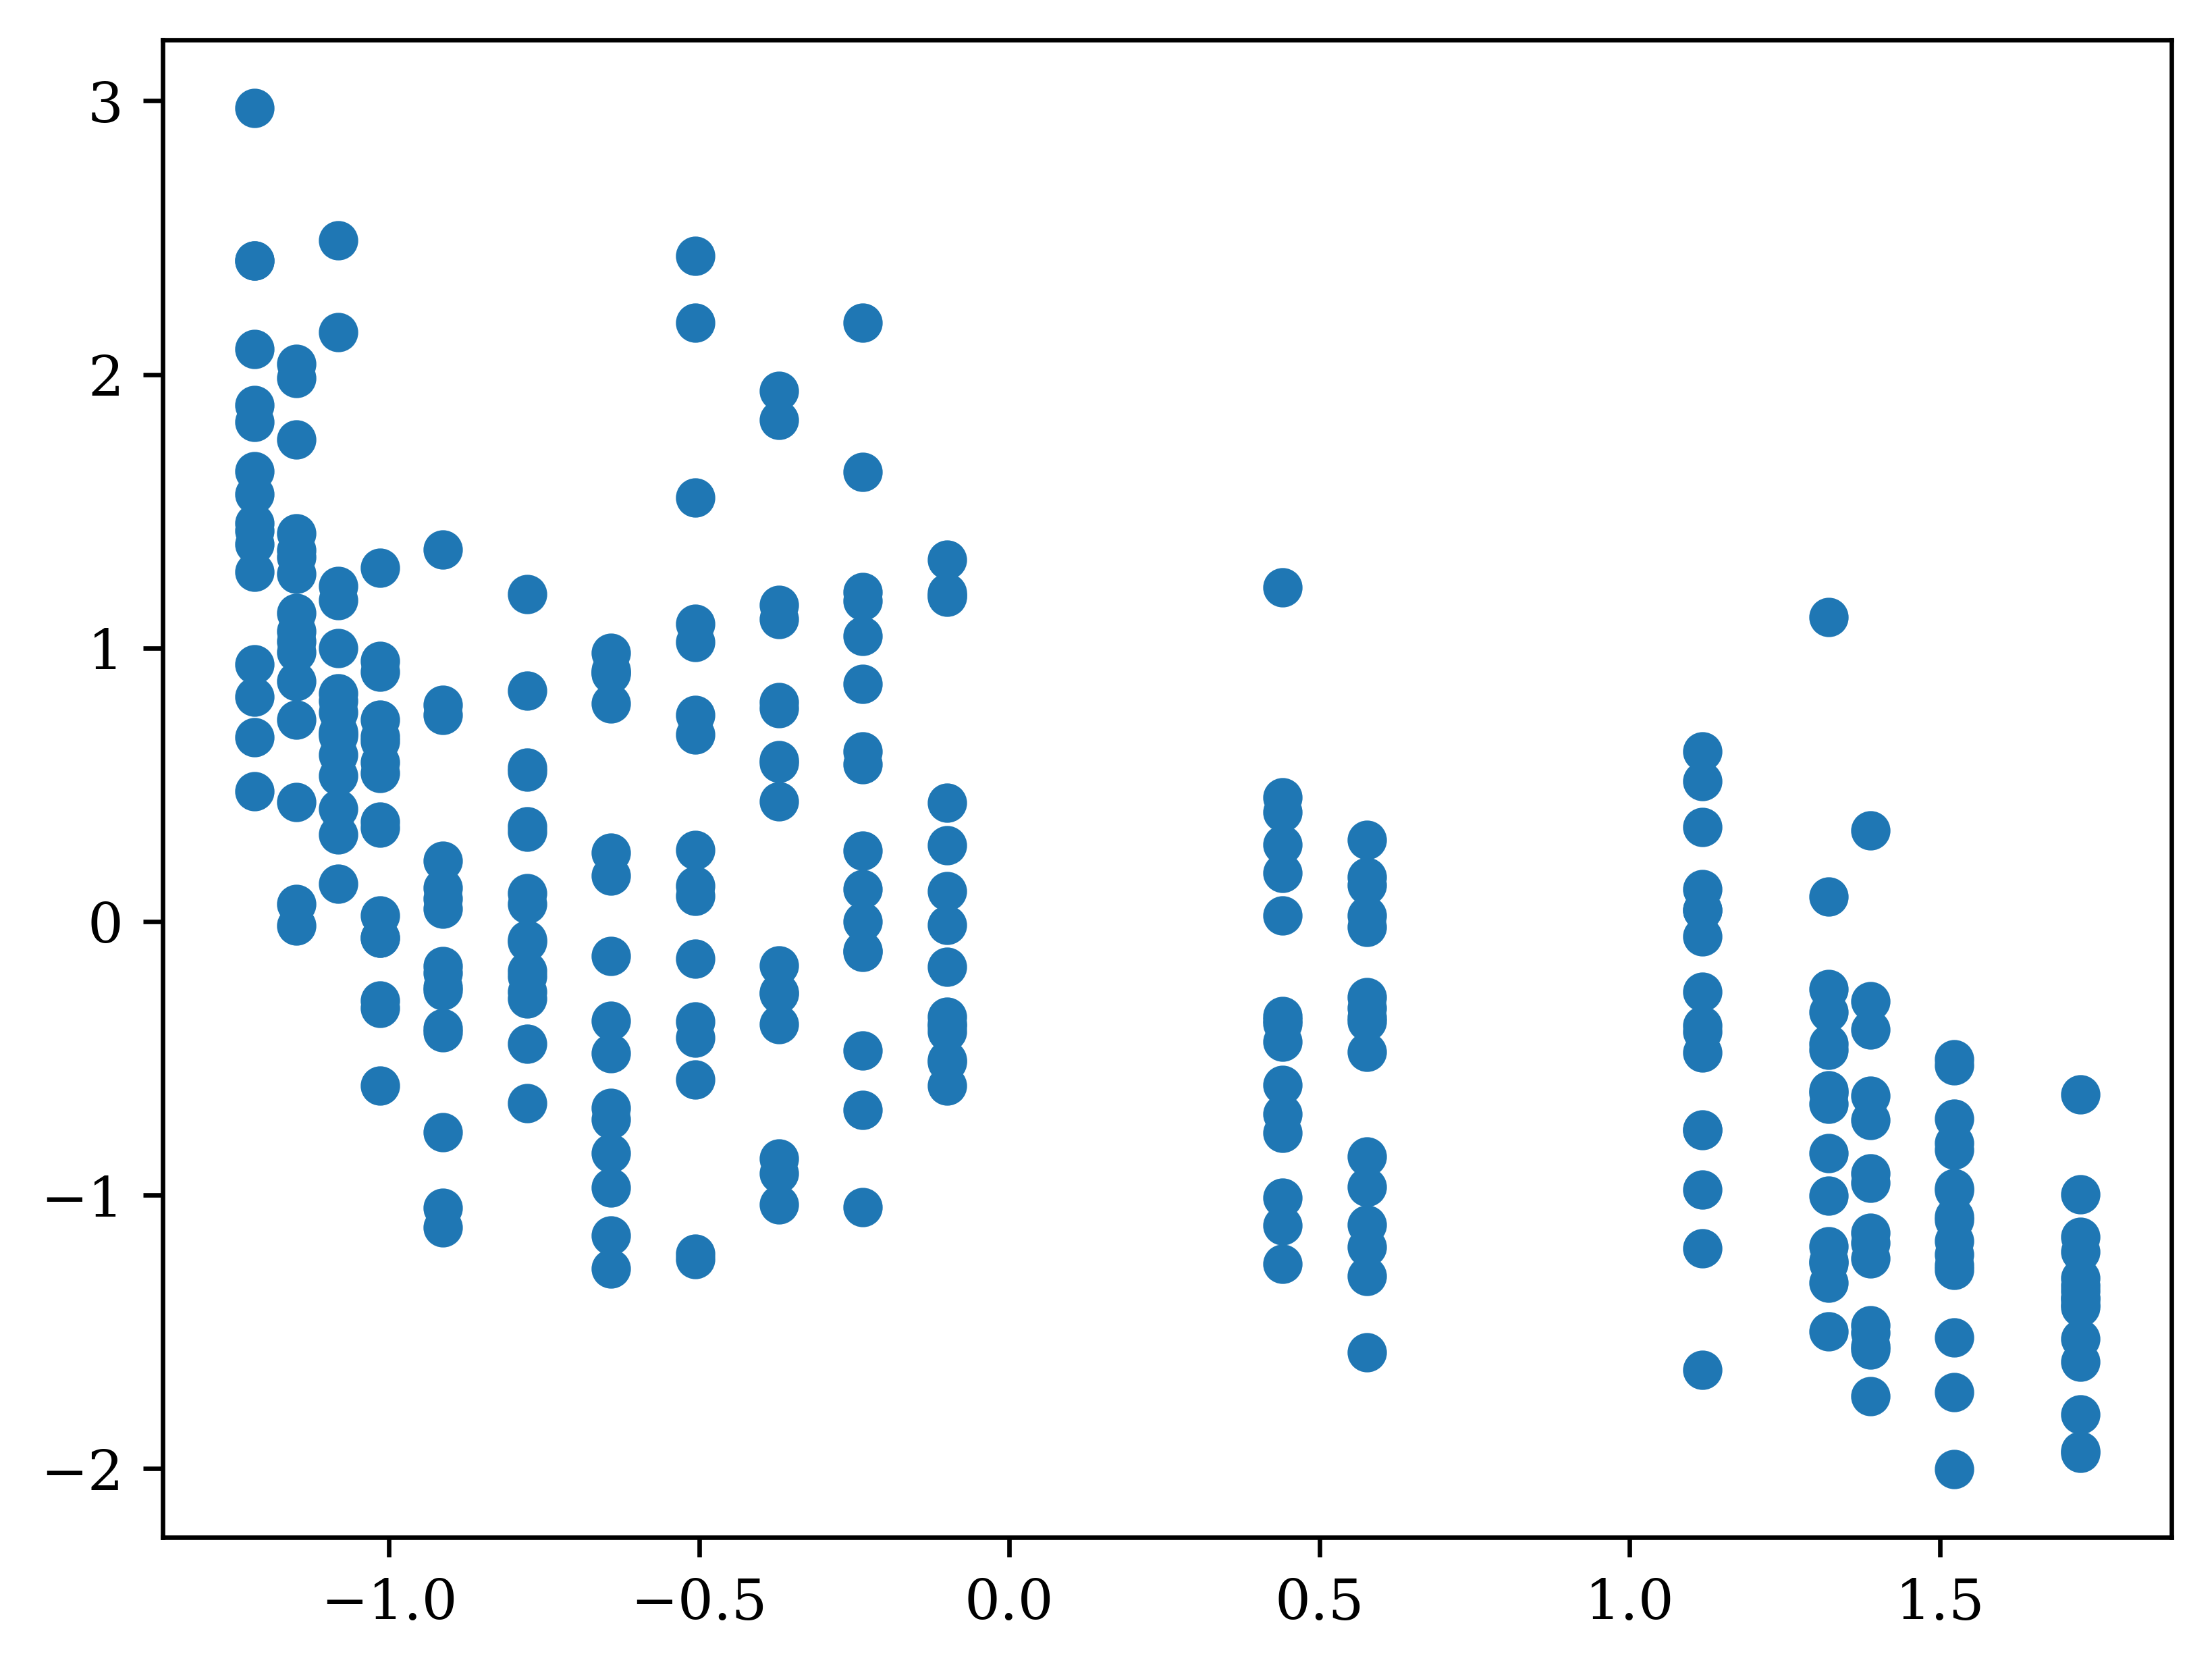

In [11]:
plt.plot(x, y[:, 0], 'o')

In [49]:
params = dict(
    l1=np.logspace(-5, -1, 9).tolist() + np.arange(0.2, 1.1, 0.2).tolist(),
    # lr=np.logspace(-4, -1, 4).tolist() + np.arange(0.2, 1.1, 0.1).tolist(),
)

In [50]:
cv = GridSearchCV(mdl, params, cv=ShuffleSplit(n_splits=6, test_size=0.5, random_state=0))
best_mdls = {}
grads = {}
scores = {}
for syll in tqdm(range(50)):
    cv = cv.fit(x, y[:, syll])
    print(syll, cv.best_params_, round(cv.best_score_, 2))
    est = deepcopy(cv.best_estimator_).fit(x, y[:, syll])
    best_mdls[syll] = est
    grads[syll] = est.gradient(time)
    scores[syll] = cv.best_score_

  0%|          | 0/50 [00:00<?, ?it/s]

0 {'l1': 0.03162277660168379} 0.43
1 {'l1': 1e-05} 0.62
2 {'l1': 0.01} 0.68
3 {'l1': 0.2} 0.65
4 {'l1': 0.2} 0.42
5 {'l1': 0.0001} 0.26
6 {'l1': 1e-05} 0.49
7 {'l1': 0.1} 0.03
8 {'l1': 0.03162277660168379} 0.51
9 {'l1': 0.1} 0.57
10 {'l1': 0.03162277660168379} 0.46
11 {'l1': 0.2} 0.46
12 {'l1': 0.1} 0.04
13 {'l1': 1e-05} 0.22
14 {'l1': 0.001} 0.11
15 {'l1': 0.2} 0.08
16 {'l1': 3.1622776601683795e-05} 0.64
17 {'l1': 0.03162277660168379} 0.31
18 {'l1': 0.2} 0.03
19 {'l1': 0.6000000000000001} 0.08
20 {'l1': 1.0} -0.0
21 {'l1': 0.001} 0.19
22 {'l1': 0.03162277660168379} 0.16
23 {'l1': 0.2} 0.44
24 {'l1': 0.2} 0.3
25 {'l1': 0.001} 0.36
26 {'l1': 1e-05} 0.45
27 {'l1': 0.2} 0.39
28 {'l1': 3.1622776601683795e-05} 0.01
29 {'l1': 0.1} 0.51
30 {'l1': 0.0031622776601683794} 0.02
31 {'l1': 0.2} 0.53
32 {'l1': 0.4} 0.3
33 {'l1': 0.03162277660168379} 0.67
34 {'l1': 0.03162277660168379} 0.69
35 {'l1': 0.00031622776601683794} 0.1
36 {'l1': 0.6000000000000001} 0.29
37 {'l1': 0.2} 0.14
38 {'l1': 1.0} -0.

In [60]:
score_thresh = 0.15
keep_mdls = keyfilter(lambda k: scores[k] > score_thresh, best_mdls)
keep_grads = keyfilter(lambda k: scores[k] > score_thresh, grads)

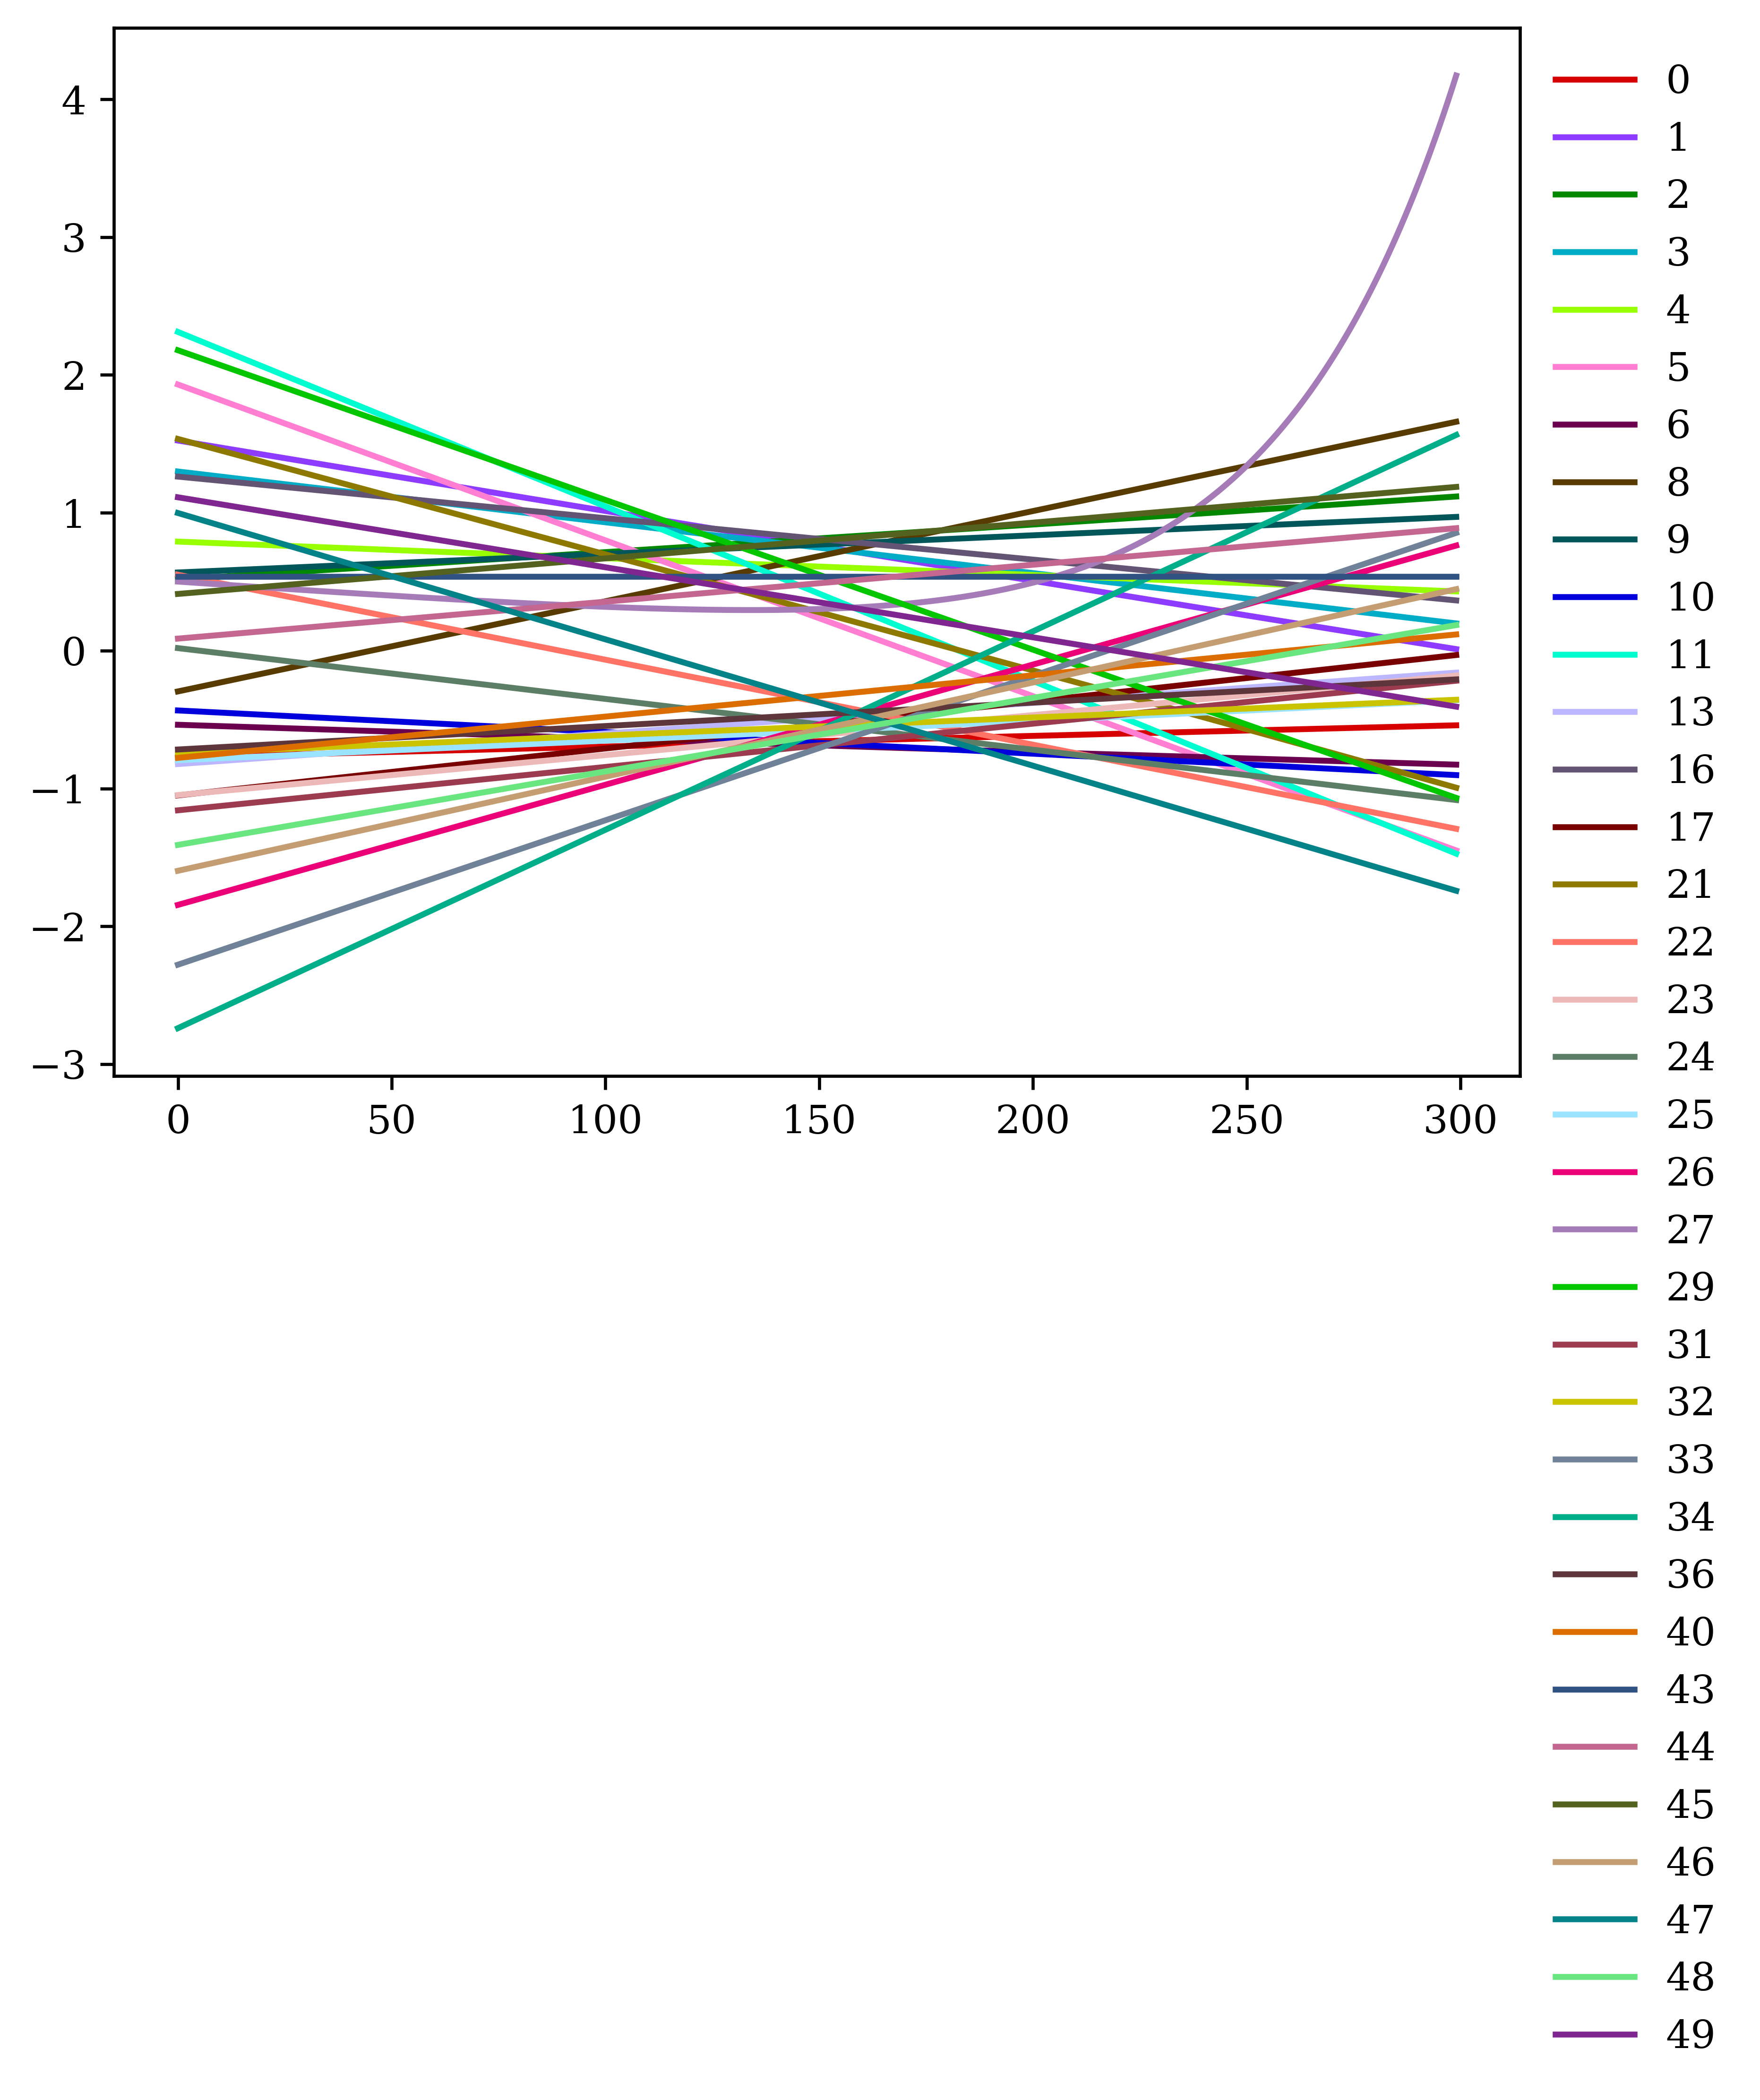

In [61]:
for k, v in keep_grads.items():
    plt.plot(v, label=k, c=cc.glasbey[k])
legend()

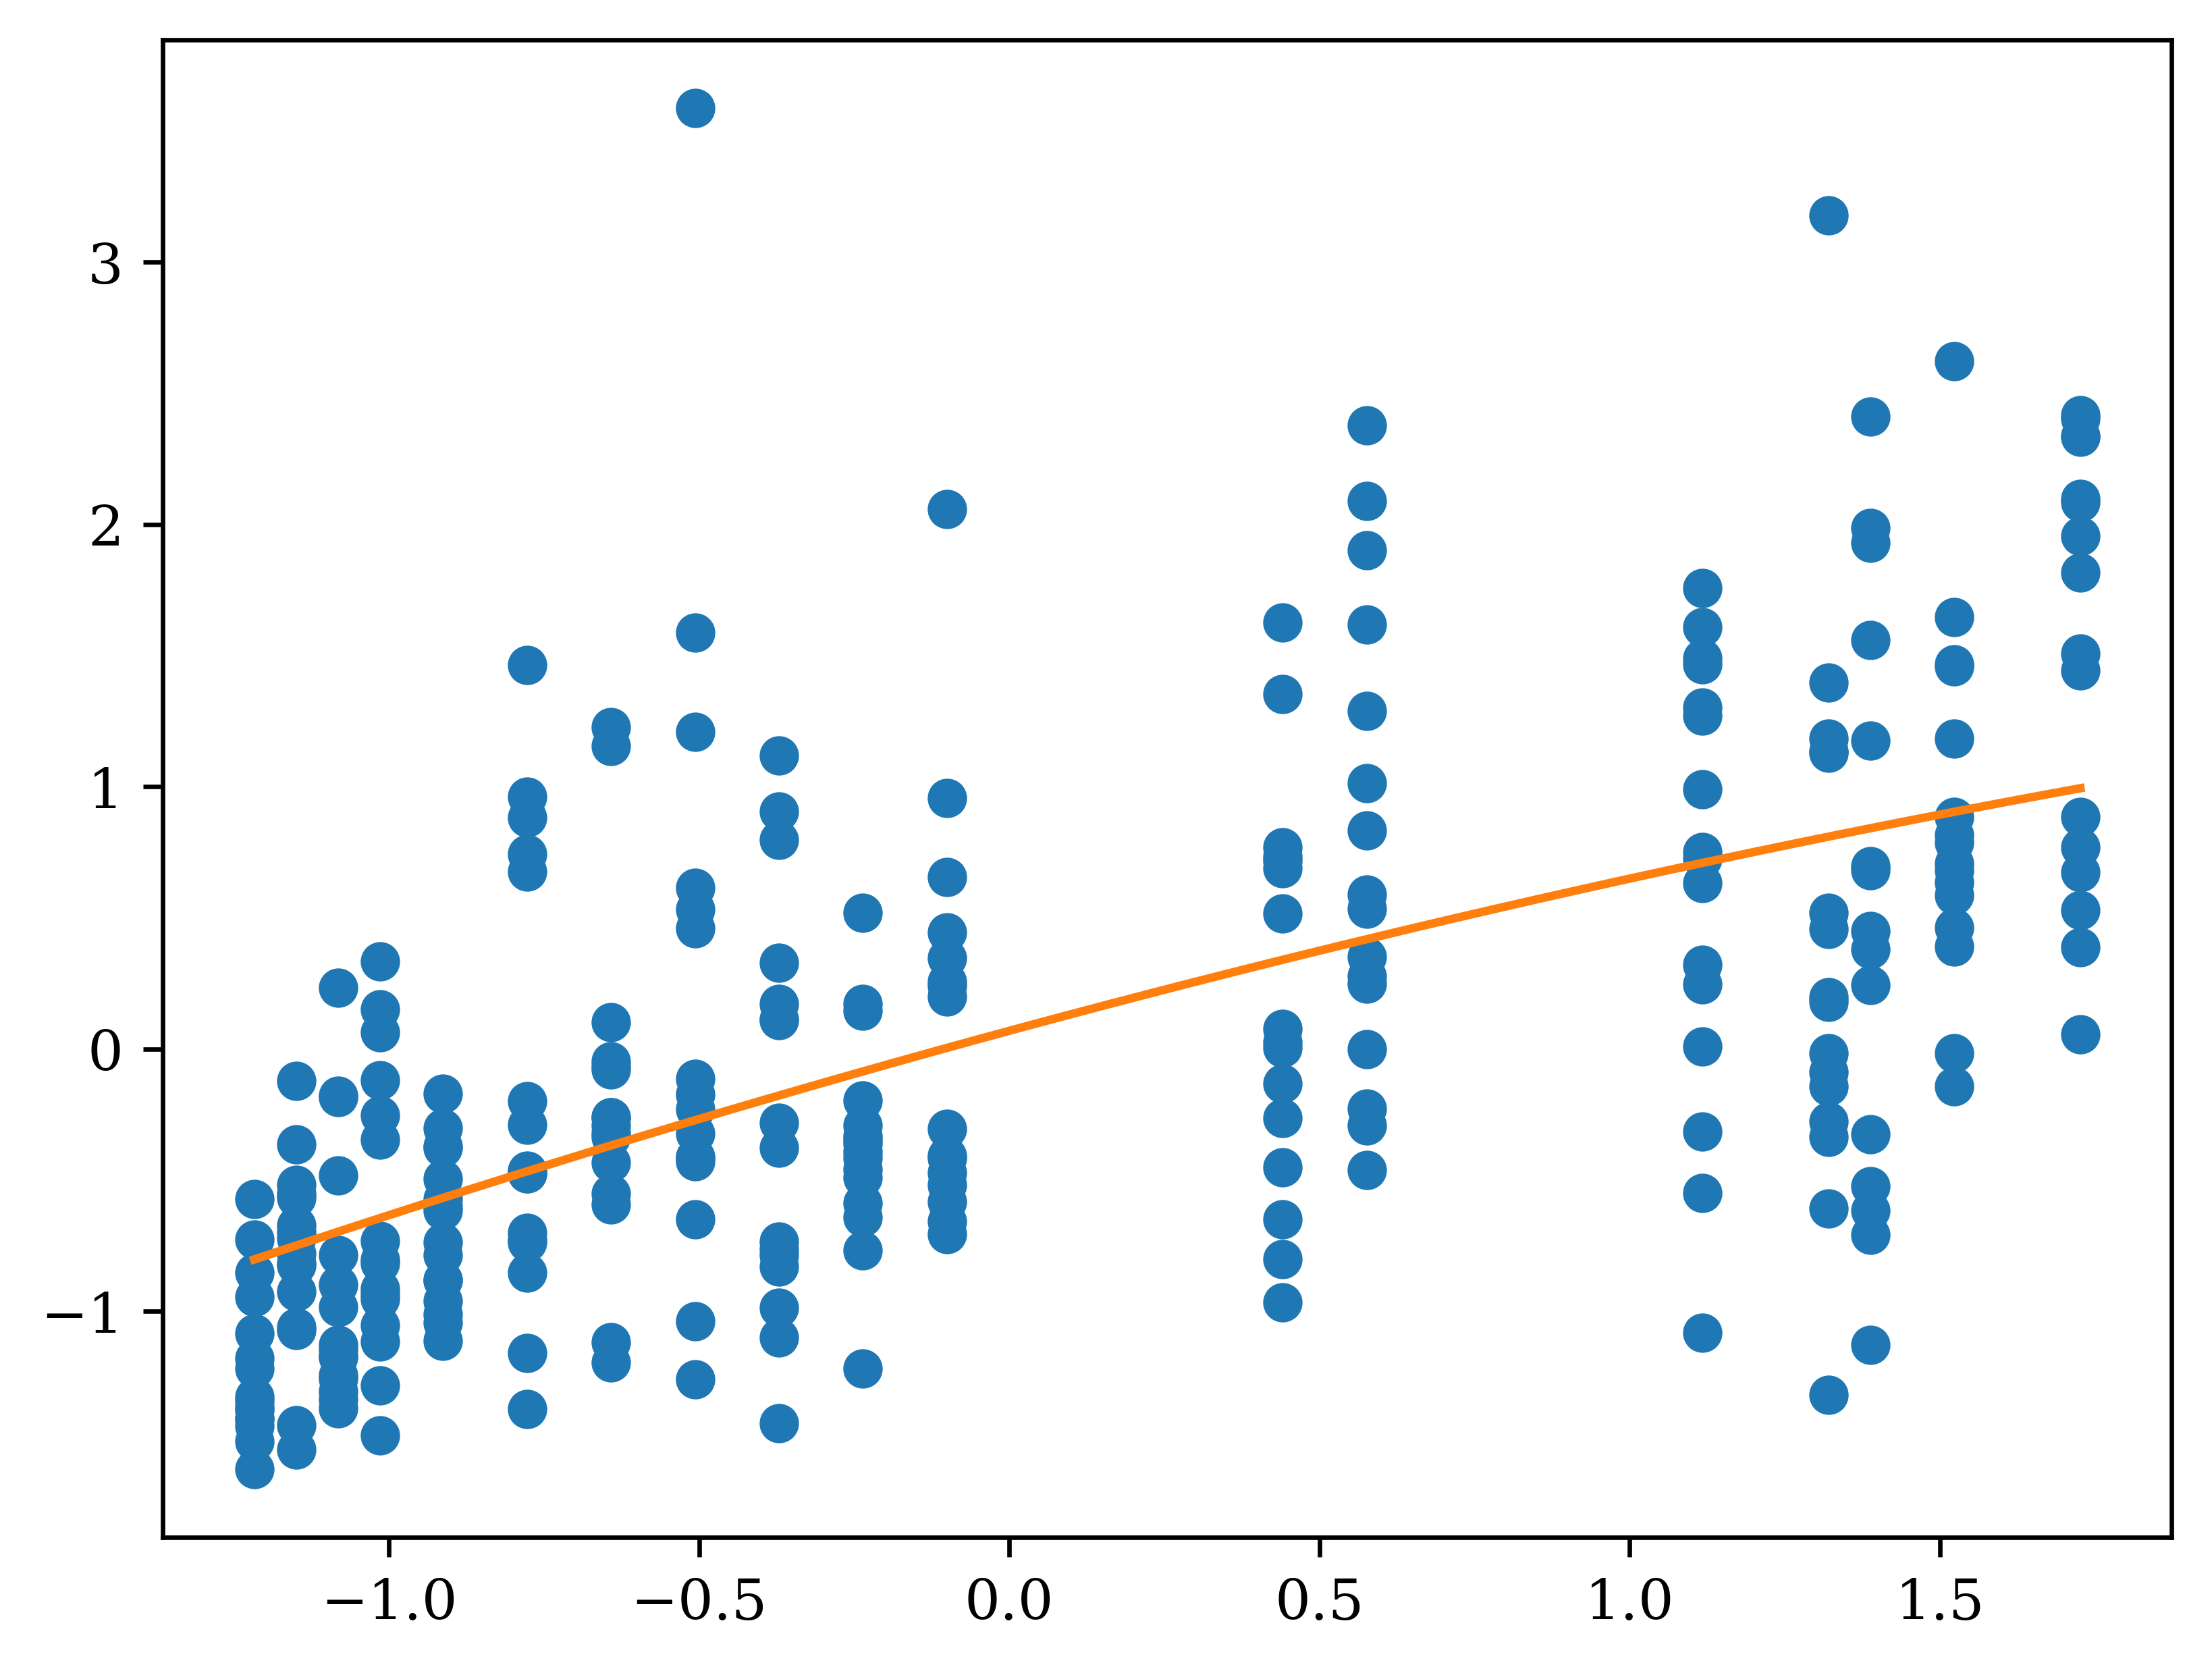

In [66]:
syll_ = 4
plt.plot(x, y[:, syll_], 'o')
plt.plot(time, keep_mdls[syll_].predict(time))

In [67]:
grad_array = np.array(list(keep_grads.values()))

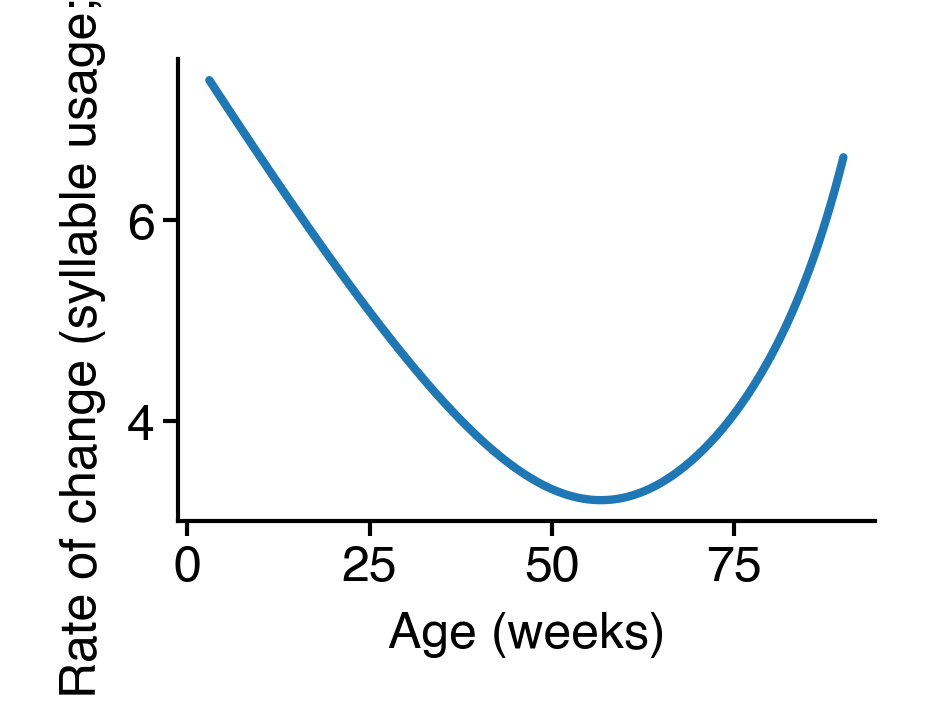

In [77]:
fig = figure(1.5, 1)
plt.plot(age_scaler.inverse_transform(time), np.linalg.norm(grad_array, axis=0))
plt.ylabel("Rate of change (syllable usage; a.u.)")
plt.xlabel('Age (weeks)')
sns.despine()
saver(fig, "ontogeny-rate-of-change");

## Longtogeny v2

### Males

In [95]:
version = 7  # arhmm version
df = pd.read_parquet(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longv2_males_clean_v2.parquet"
)
# df.set_index(['pseudo_age', 'pseudo_age_smooth'], inplace=True, append=True)
# df = df[df.index.get_level_values('age') < 600]

In [97]:
coef_shapes = {
    "exponential_params": dict(a=(1, 1), b=(1, 1), c=(1, 1), offset=(1, 1)),
    "linear_params": dict(m=(1, 1), b=(1, 1)),
    "logistic_params": dict(m=(1, 1), b=(1, 1), offset=(1, 1), scale=(1, 1)),
    "quadratic_params": dict(a=(1, 1), b=(1, 1), c=(1, 1)),
    "submodel_weights": (4, 1),
}

In [98]:
mdl = JaxRegressor(
    jit=True,
    model=multi_model_function,
    loss_fun=model_loss_l1,
    n_iter=50,
    coef_shapes=coef_shapes,
    l1=1e-1,
    lr=1e-1,
)

In [101]:
age_scaler = StandardScaler()
x = age_scaler.fit_transform(df.index.get_level_values('age').to_numpy()[:, None])
y = StandardScaler().fit_transform(df)
time = np.linspace(np.min(x), np.max(x), 300)[:, None]

In [102]:
best_mdls = {}
grads = {}
scores = {}
for syll in tqdm(range(50)):
    scores[syll] = cross_val_score(
        mdl, x, y[:, syll], cv=ShuffleSplit(n_splits=4, test_size=0.35, random_state=0)
    )
    est = deepcopy(mdl).fit(x, y[:, syll])
    best_mdls[syll] = est
    grads[syll] = est.gradient(time)

  0%|          | 0/50 [00:00<?, ?it/s]

In [103]:
score_thresh = 0.15
keep_mdls = keyfilter(lambda k: scores[k].mean() > score_thresh, best_mdls)
keep_grads = keyfilter(lambda k: scores[k].mean() > score_thresh, grads)

In [104]:
grad_array = np.array(list(keep_grads.values()))

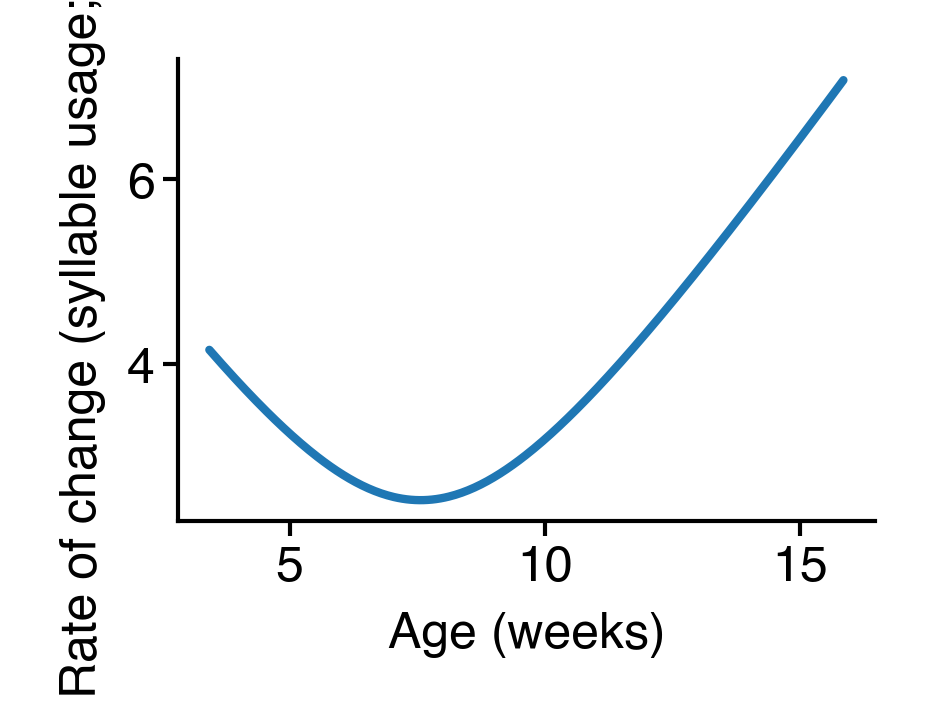

In [107]:
fig = figure(1.5, 1)
plt.plot(age_scaler.inverse_transform(time) / 7, np.linalg.norm(grad_array, axis=0))
plt.ylabel("Rate of change (syllable usage; a.u.)")
plt.xlabel('Age (weeks)')
sns.despine()
saver(fig, "longtogeny-v2-males-rate-of-change");

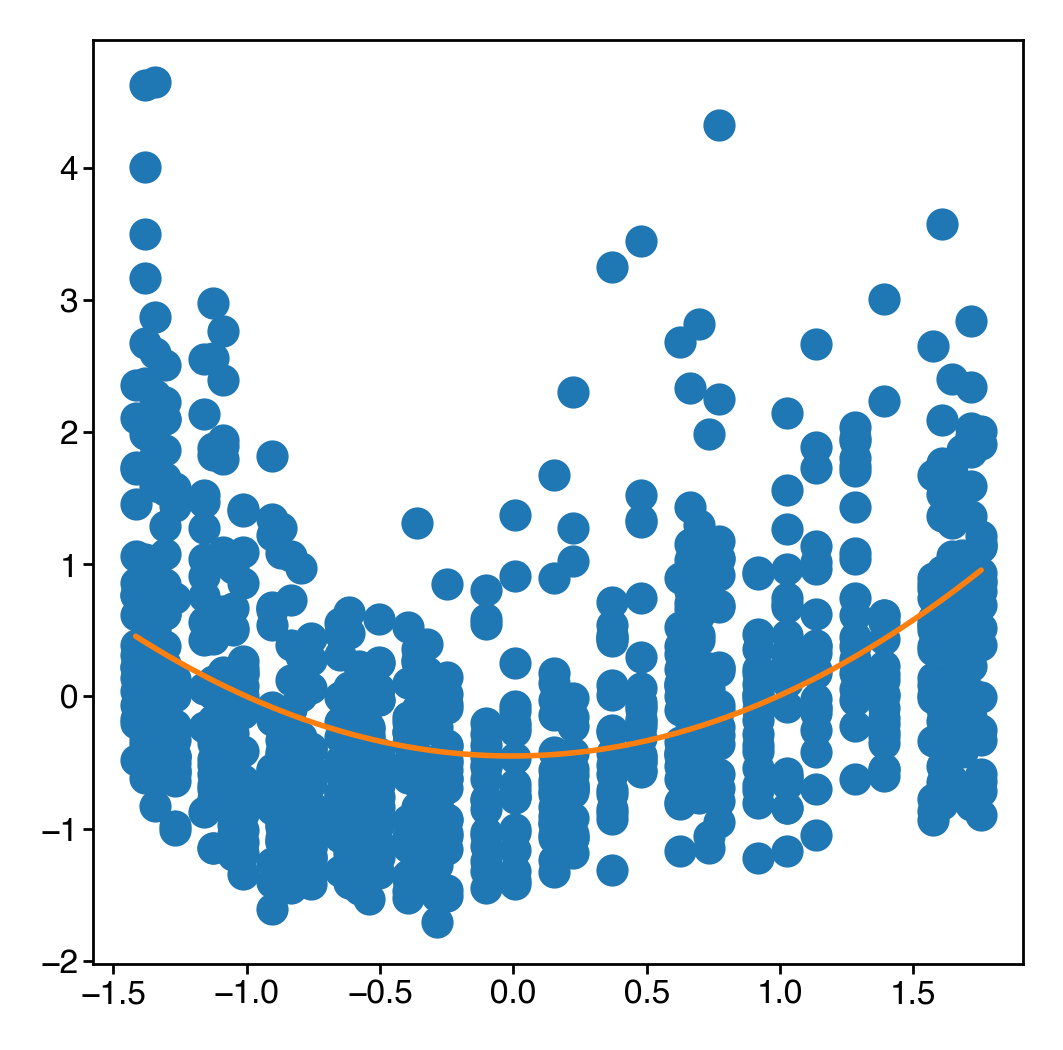

In [106]:
syll_ = 4
plt.plot(x, y[:, syll_], 'o')
plt.plot(time, keep_mdls[syll_].predict(time))

### Females

In [116]:
version = 7  # arhmm version
df = pd.read_parquet(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longv2_females_clean_v2.parquet"
)
# df.set_index(['pseudo_age', 'pseudo_age_smooth'], inplace=True, append=True)
# df = df[df.index.get_level_values('age') < 600]

In [117]:
mdl = JaxRegressor(
    jit=True,
    model=multi_model_function,
    loss_fun=model_loss_l1,
    n_iter=50,
    coef_shapes=coef_shapes,
    l1=1e-1,
    lr=1e-1,
)

In [118]:
x = age_scaler.transform(df.index.get_level_values('age').to_numpy()[:, None])
y = StandardScaler().fit_transform(df)

In [119]:
best_mdls = {}
grads = {}
scores = {}
for syll in tqdm(range(50)):
    scores[syll] = cross_val_score(
        mdl, x, y[:, syll], cv=ShuffleSplit(n_splits=4, test_size=0.35, random_state=0)
    )
    est = deepcopy(mdl).fit(x, y[:, syll])
    best_mdls[syll] = est
    grads[syll] = est.gradient(time)

  0%|          | 0/50 [00:00<?, ?it/s]

In [120]:
score_thresh = 0.15
keep_mdls = keyfilter(lambda k: scores[k].mean() > score_thresh, best_mdls)
keep_grads = keyfilter(lambda k: scores[k].mean() > score_thresh, grads)

In [121]:
f_grad_array = np.array(list(keep_grads.values()))

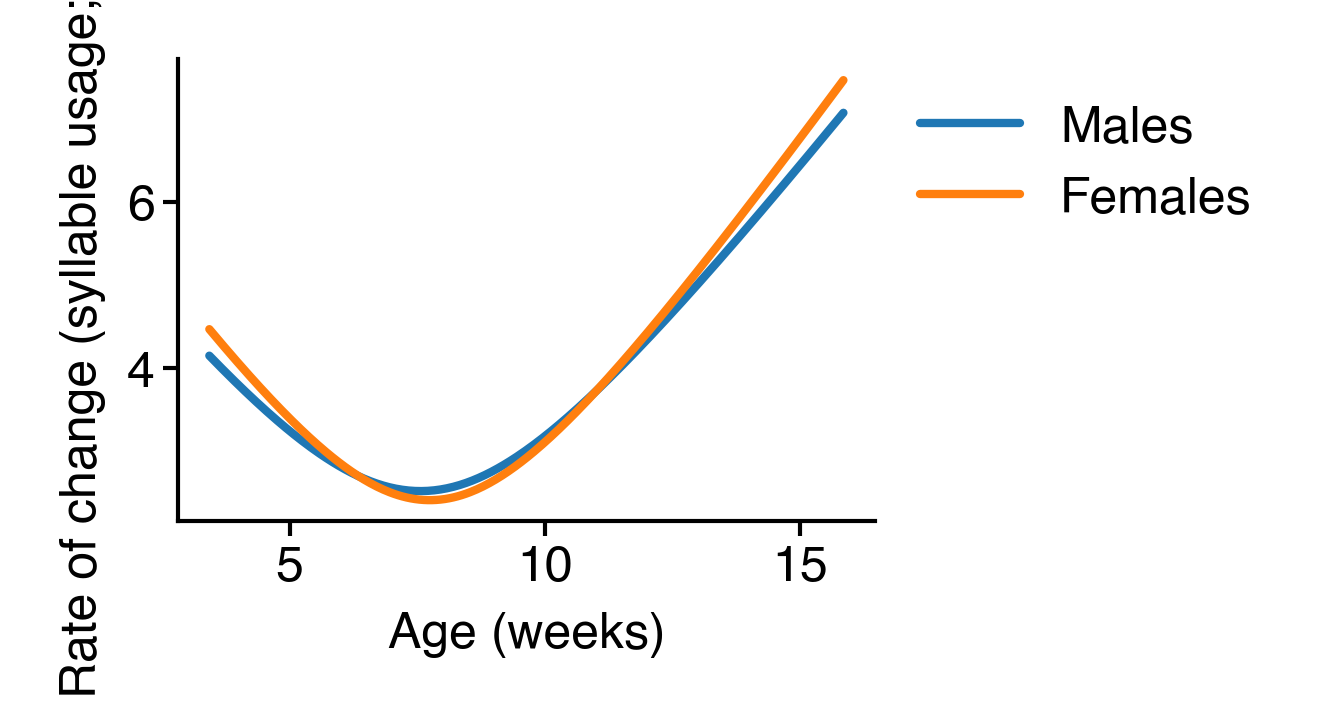

In [122]:
fig = figure(1.5, 1)
plt.plot(age_scaler.inverse_transform(time) / 7, np.linalg.norm(grad_array, axis=0), label="Males")
plt.plot(age_scaler.inverse_transform(time) / 7, np.linalg.norm(f_grad_array, axis=0), label="Females")
plt.ylabel("Rate of change (syllable usage; a.u.)")
plt.xlabel('Age (weeks)')
sns.despine()
legend()
saver(fig, "longtogeny-v2-males-females-rate-of-change");

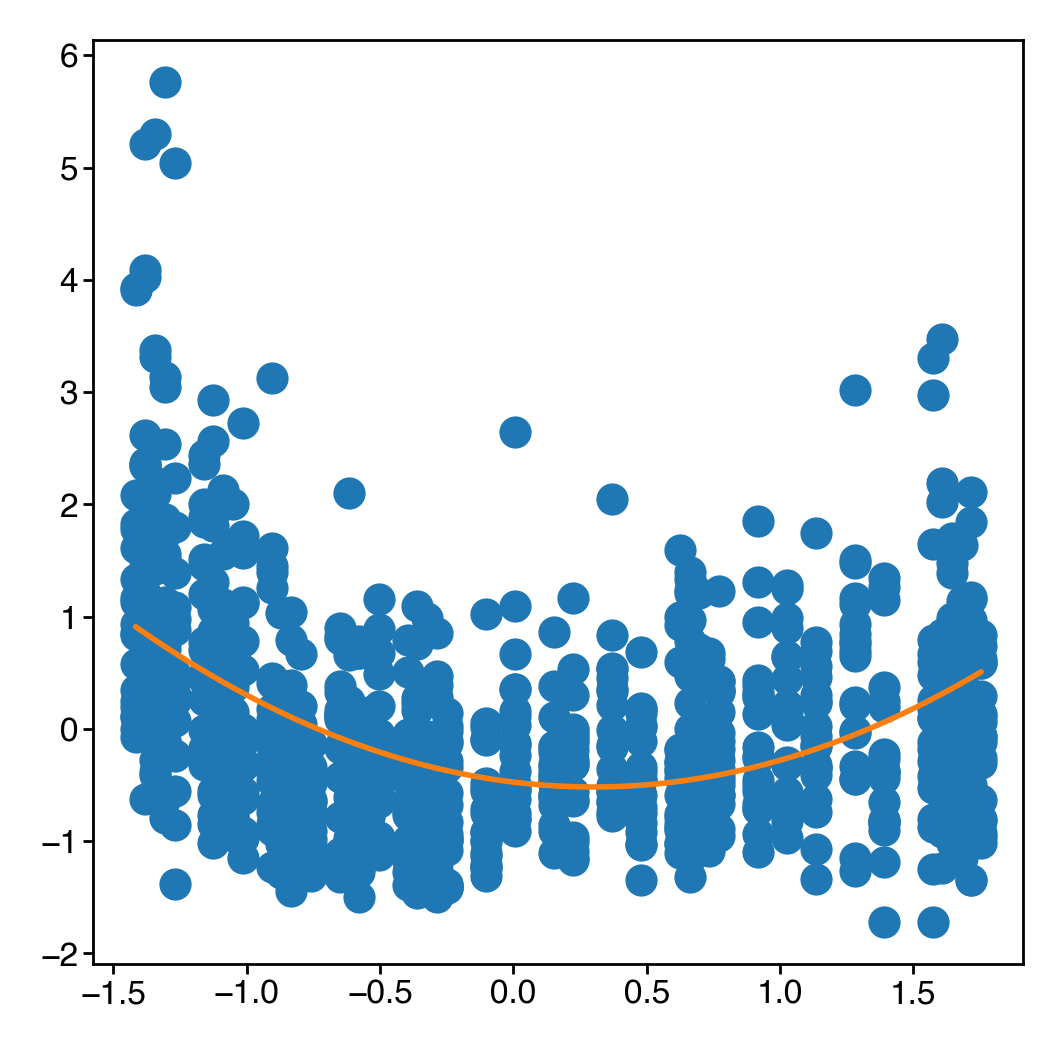

In [123]:
syll_ = 4
plt.plot(x, y[:, syll_], 'o')
plt.plot(time, keep_mdls[syll_].predict(time))